In [1]:
!pip install -q -U tensorflow-text --quiet

In [2]:
!pip install h5py
!pip install typing-extensions
!pip install wheel

In [3]:
!pip install tf-models-official

In [4]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [5]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

# keras uitlity to download a file
dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url, untar=True, cache_dir='.', cache_subdir='')

In [6]:
dataset_dir = '/content/aclImdb'

train_dir = os.path.join(dataset_dir,'train')

In [7]:
# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [8]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 16
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [9]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review: b"I pity people calling kamal hassan 'ulaganaayakan' maybe for them ulagam is tollywood ! comeon guys..this movie is a thriller without thrill..<br /><br />come out of your ulagam and just watch some high class 

In [10]:
tfhub_handle_preprocess="https://tfhub.dev/jeongukjae/xlm_roberta_multi_cased_preprocess/1"
tfhub_handle_encoder="https://tfhub.dev/jeongukjae/xlm_roberta_multi_cased_L-12_H-768_A-12/1"

In [11]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [12]:
text_test = ['this is such an amazing movie!. I hate the movie', 'hello world']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"]}')

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (2, 128)
Word Ids   : [    0   903    83  6044   142 44613 14277    38     5    87 35463    70]
Input Mask : [[1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
Type Ids   : [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0

In [13]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [14]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/jeongukjae/xlm_roberta_multi_cased_L-12_H-768_A-12/1
Pooled Outputs Shape:(2, 768)
Pooled Outputs Values:[-0.05977109  0.19162206  0.07797356  0.52624065  0.04085281  0.3737557
  0.40056783 -0.35305947  0.2206645  -0.13416736 -0.01673371  0.1454065 ]
Sequence Outputs Shape:(2, 128, 768)
Sequence Outputs Values:[[ 0.10853481  0.07160056  0.04896161 ... -0.11889581  0.1056497
  -0.0373538 ]
 [-0.06254289 -0.00051679  0.01418203 ...  0.10999945  0.04440661
   0.08431862]
 [-0.04889844  0.02585154  0.03390668 ...  0.3069808   0.02681921
   0.14518717]
 ...
 [-0.08459289  0.06235805 -0.00367711 ...  0.0750566   0.09014092
   0.14542823]
 [-0.17076437  0.11358617  0.00150472 ... -0.03710076  0.06940719
  -0.2500791 ]
 [-0.02571064 -0.06413631 -0.00308123 ...  0.08950476  0.03539164
   0.13073198]]


In [15]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='XLM-RoBERTa_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [16]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor(
[[0.43285906]
 [0.43432695]], shape=(2, 1), dtype=float32)


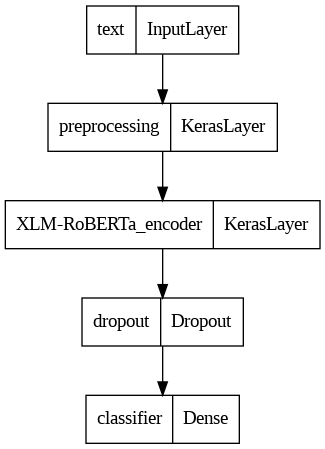

In [17]:
tf.keras.utils.plot_model(classifier_model)

In [18]:
from keras.metrics import Precision, Recall,F1Score,AUC,TruePositives,TrueNegatives,FalsePositives,FalseNegatives
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
#metrics = tf.metrics.BinaryAccuracy()
metrics=['accuracy', Precision(), Recall(),AUC(),TruePositives(),TrueNegatives(),FalsePositives(),FalseNegatives()]

In [19]:
epochs = 3
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [20]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [21]:
import time

In [22]:
%%time
print(f'Training model with {tfhub_handle_encoder}')
start_time = time.time()  # Record the start time
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)
end_time = time.time()  # Record the end time
training_time = end_time - start_time  # Calculate the training time
print(f"Training time: {training_time:.2f} seconds")

Training model with https://tfhub.dev/jeongukjae/xlm_roberta_multi_cased_L-12_H-768_A-12/1
Epoch 1/3
1250/1250 [==============================] - 205s 151ms/step - loss: 0.4305 - accuracy: 0.8009 - precision: 0.8595 - recall: 0.7176 - auc: 0.8310 - true_positives: 7149.0000 - true_negatives: 8869.0000 - false_positives: 1169.0000 - false_negatives: 2813.0000 - val_loss: 0.3734 - val_accuracy: 0.8550 - val_precision: 0.8171 - val_recall: 0.9204 - val_auc: 0.8742 - val_true_positives: 2336.0000 - val_true_negatives: 1939.0000 - val_false_positives: 523.0000 - val_false_negatives: 202.0000
Epoch 2/3
1250/1250 [==============================] - 187s 150ms/step - loss: 0.2774 - accuracy: 0.8953 - precision: 0.9086 - recall: 0.8780 - auc: 0.9096 - true_positives: 8747.0000 - true_negatives: 9158.0000 - false_positives: 880.0000 - false_negatives: 1215.0000 - val_loss: 0.3544 - val_accuracy: 0.8722 - val_precision: 0.8558 - val_recall: 0.8999 - val_auc: 0.8834 - val_true_positives: 2284.0000 

In [23]:
# evaluate the model on train datset
train_loss, train_accuracy,train_precision, train_recall,train_auc,train_tp, train_tn, train_fp, train_fn  = classifier_model.evaluate(train_ds)

1250/1250 [==============================] - 98s 78ms/step - loss: 0.1121 - accuracy: 0.9698 - precision: 0.9628 - recall: 0.9771 - auc: 0.9727 - true_positives: 9734.0000 - true_negatives: 9662.0000 - false_positives: 376.0000 - false_negatives: 228.0000


In [24]:
def calculate_f1_score(precision, recall):
    f1_score = (2 * precision * recall) / (precision + recall)
    return f1_score


In [25]:
# Calculate F1 score
train_f1 = calculate_f1_score(train_precision, train_recall)
print("Train Accuracy:", train_accuracy)
print("Train Precision:", train_precision)
print("Train Recall:", train_recall)
print("Train F1 Score:", train_f1)
print("Train auc Score:", train_auc)
print("Train TP Score:", train_tp)
print("Train TN Score:", train_tn)
print("Train FP Score:", train_fp)
print("Train FN Score:", train_fn)

Train Accuracy: 0.9697999954223633
Train Precision: 0.9628090858459473
Train Recall: 0.9771130084991455
Train F1 Score: 0.9699083125282364
Train auc Score: 0.9726507067680359
Train TP Score: 9734.0
Train TN Score: 9662.0
Train FP Score: 376.0
Train FN Score: 228.0


In [26]:
# evaluate the model on val datset
val_loss, val_accuracy,val_precision, val_recall,val_auc,val_tp, val_tn, val_fp, val_fn  = classifier_model.evaluate(val_ds)

313/313 [==============================] - 25s 80ms/step - loss: 0.4617 - accuracy: 0.8778 - precision: 0.8742 - recall: 0.8869 - auc: 0.8830 - true_positives: 2251.0000 - true_negatives: 2138.0000 - false_positives: 324.0000 - false_negatives: 287.0000


In [27]:
def calculate_f1_score(precision, recall):
    f1_score = (2 * precision * recall) / (precision + recall)
    return f1_score

In [28]:
# Calculate F1 score
VAL_f1 = calculate_f1_score(val_precision, val_recall)
print("VAL Accuracy:", val_accuracy)
print("VAL Precision:", val_precision)
print("VAL Recall:", val_recall)
print("VAL F1 Score:", VAL_f1)
print("VAL auc Score:", val_auc)
print("VAL TP Score:", val_tp)
print("VAL TN Score:", val_tn)
print("VAL FP Score:", val_fp)
print("VAL FN Score:", val_fn)

VAL Accuracy: 0.8777999877929688
VAL Precision: 0.8741747736930847
VAL Recall: 0.886918842792511
VAL F1 Score: 0.880500697321808
VAL auc Score: 0.8830457925796509
VAL TP Score: 2251.0
VAL TN Score: 2138.0
VAL FP Score: 324.0
VAL FN Score: 287.0


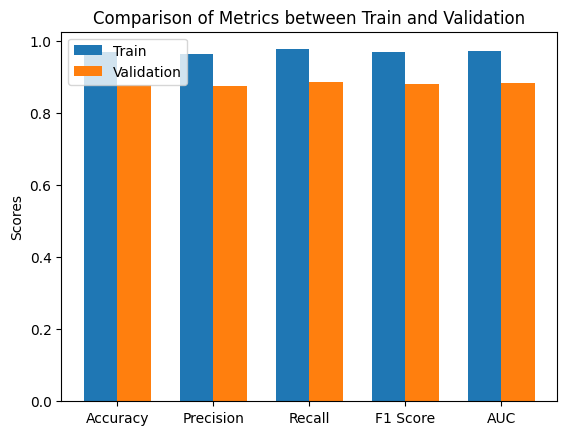

In [29]:
# Metrics for Train and Validation
metrics_names = ["Accuracy", "Precision", "Recall", "F1 Score", "AUC"]
train_metrics = [train_accuracy, train_precision, train_recall, train_f1, train_auc]
val_metrics = [val_accuracy, val_precision, val_recall, VAL_f1, val_auc]

# Plotting
x = range(len(metrics_names))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x, train_metrics, width, label='Train')
rects2 = ax.bar([i + width for i in x], val_metrics, width, label='Validation')

ax.set_ylabel('Scores')
ax.set_title('Comparison of Metrics between Train and Validation')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(metrics_names)
ax.legend()

plt.show()

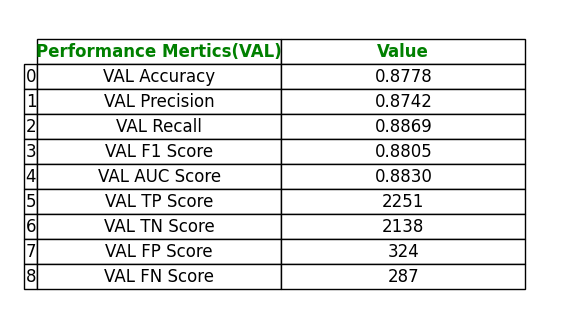

In [30]:
import matplotlib.pyplot as plt
from pandas.plotting import table

# Sample values
evaluation_metrics = ['VAL Accuracy', 'VAL Precision', 'VAL Recall', 'VAL F1 Score','VAL AUC Score','VAL TP Score','VAL TN Score','VAL FP Score','VAL FN Score']
values = [format(val_accuracy, ".4f"),format(val_precision, ".4f") , format(val_recall, ".4f"), format(VAL_f1, ".4f"),format(val_auc, ".4f"),format(val_tp, ".0f"),format(val_tn, ".0f"),format(val_fp, ".0f"),format(val_fn, ".0f")]

# Create a DataFrame to store the evaluation metrics
import pandas as pd
data = {'Performance Mertics(VAL)': evaluation_metrics, 'Value': values}
df = pd.DataFrame(data)

# Create a plot
fig, ax = plt.subplots(figsize=(7, 4))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create a table without borders and headers
tab = table(ax, df, loc='center', cellLoc='center', colWidths=[0.3, 0.3])
tab.auto_set_font_size(False)
tab.set_fontsize(12)
tab.scale(1.5, 1.5)

# Change color of headers and make them bold
for key, cell in tab.get_celld().items():
    if key[0] == 0:  # Header row
        cell.set_text_props(weight='bold', color='green')

plt.savefig('evaluation_metrics_table.png', dpi=300, bbox_inches='tight')
plt.show()

In [31]:
# evaluate the model on test data

test_loss, test_accuracy, test_precision, test_recall, test_auc, test_tp, test_tn, test_fp, test_fn = classifier_model.evaluate(test_ds)

1563/1563 [==============================] - 123s 79ms/step - loss: 0.4423 - accuracy: 0.8813 - precision: 0.8689 - recall: 0.8981 - auc: 0.8879 - true_positives: 11226.0000 - true_negatives: 10806.0000 - false_positives: 1694.0000 - false_negatives: 1274.0000


In [32]:
def calculate_f1_score(precision, recall):
    f1_score = (2 * precision * recall) / (precision + recall)
    return f1_score


In [33]:
# Calculate F1 score
f1 = calculate_f1_score(test_precision, test_recall)
print("TEST Accuracy:", test_accuracy)
print("TEST Precision:", test_precision)
print("TEST Recall:", test_recall)
print("TEST F1 Score:", f1)
print("TEST auc Score:", test_auc)
print("TEST TP Score:", test_tp)
print("TEST TN Score:", test_tn)
print("TEST FP Score:", test_fp)
print("TEST FN Score:", test_fn)


TEST Accuracy: 0.8812800049781799
TEST Precision: 0.8688854575157166
TEST Recall: 0.8980799913406372
TEST F1 Score: 0.8832415423479596
TEST auc Score: 0.8878760933876038
TEST TP Score: 11226.0
TEST TN Score: 10806.0
TEST FP Score: 1694.0
TEST FN Score: 1274.0


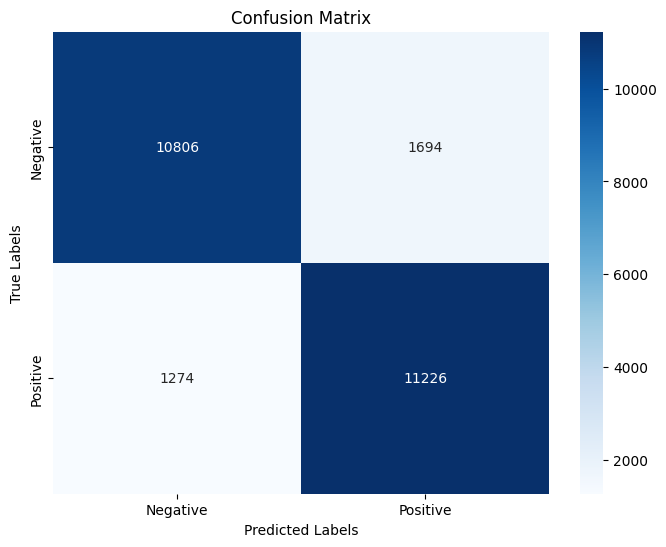

In [34]:
from sklearn.metrics import confusion_matrix,roc_curve
import numpy as np
import seaborn as sns

conf_matrix = np.array([[test_tn, test_fp],
                        [test_fn, test_tp]])

# Plot Confusion Matrix as a Heatmap
class_names = ['Negative', 'Positive']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".0f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

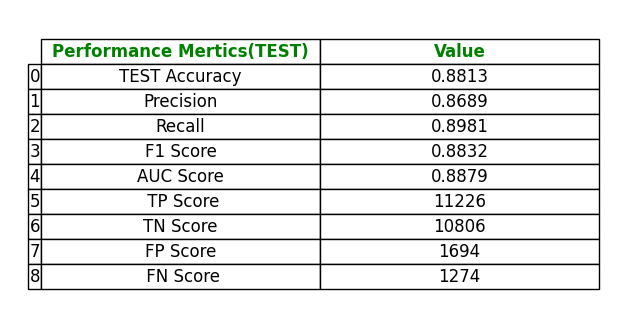

In [35]:
import matplotlib.pyplot as plt
from pandas.plotting import table

# Sample values
evaluation_metrics = ['TEST Accuracy', 'Precision', 'Recall', 'F1 Score','AUC Score',' TP Score','TN Score','FP Score',' FN Score']
values = [format(test_accuracy, ".4f"),format(test_precision, ".4f") , format(test_recall, ".4f"), format(f1, ".4f"), format(test_auc, ".4f"), format(test_tp, ".0f"), format(test_tn, ".0f"), format(test_fp, ".0f"), format(test_fn, ".0f"),]

# Create a DataFrame to store the evaluation metrics
import pandas as pd
data = {'Performance Mertics(TEST)': evaluation_metrics, 'Value': values}
df = pd.DataFrame(data)

# Create a plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create a table without borders and headers
tab = table(ax, df, loc='center', cellLoc='center', colWidths=[0.3, 0.3])
tab.auto_set_font_size(False)
tab.set_fontsize(12)
tab.scale(1.5, 1.5)

# Change color of headers and make them bold
for key, cell in tab.get_celld().items():
    if key[0] == 0:  # Header row
        cell.set_text_props(weight='bold', color='green')


plt.show()


In [36]:
from sklearn.metrics import auc

In [37]:
y_true_test = []
y_pred_test = []

for text_batch, label_batch in test_ds:
    y_true_test.extend(label_batch.numpy())
    y_pred_test.extend(classifier_model.predict(text_batch).flatten())

y_true_test = np.array(y_true_test)
y_pred_test = (np.array(y_pred_test) > 0.5).astype(int)

1/1 [==============================] - 0s 85ms/step


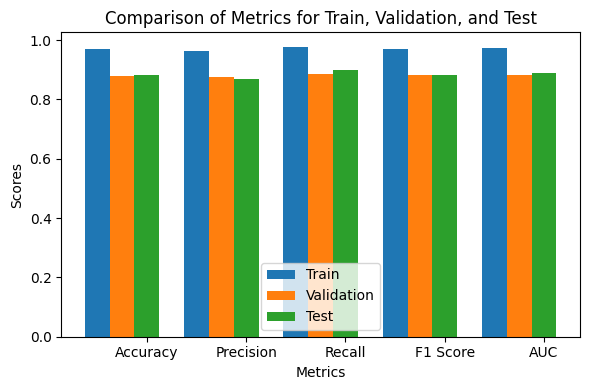

In [38]:
# Metrics for Train and Validation
metrics_names = ["Accuracy", "Precision", "Recall", "F1 Score", "AUC"]
train_metrics = [train_accuracy, train_precision, train_recall, train_f1, train_auc]
val_metrics = [val_accuracy, val_precision, val_recall, VAL_f1, val_auc]
test_metrics = [test_accuracy, test_precision, test_recall, f1, test_auc]
# Number of metrics
num_metrics = len(metrics_names)

# Plotting
fig, ax = plt.subplots(figsize=(6, 4))
bar_width = 0.25

# Set positions for the bars
positions_train = range(num_metrics)
positions_val = [pos + bar_width for pos in positions_train]
positions_test = [pos + bar_width for pos in positions_val]

# Plot bars for Train, Validation, and Test
ax.bar(positions_train, train_metrics, bar_width, label='Train')
ax.bar(positions_val, val_metrics, bar_width, label='Validation')
ax.bar(positions_test, test_metrics, bar_width, label='Test')

# Set labels and title
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Metrics for Train, Validation, and Test')
ax.set_xticks([pos + bar_width for pos in positions_val])
ax.set_xticklabels(metrics_names)
ax.legend()

plt.tight_layout()
plt.show()

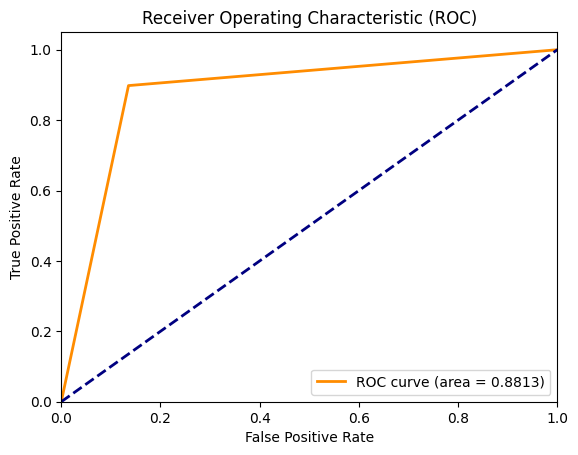

In [39]:
# Calculate ROC curve and AUC for Test Data
fpr_test, tpr_test, thresholds = roc_curve(y_true_test, y_pred_test)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'true_positives', 'true_negatives', 'false_positives', 'false_negatives', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc', 'val_true_positives', 'val_true_negatives', 'val_false_positives', 'val_false_negatives'])


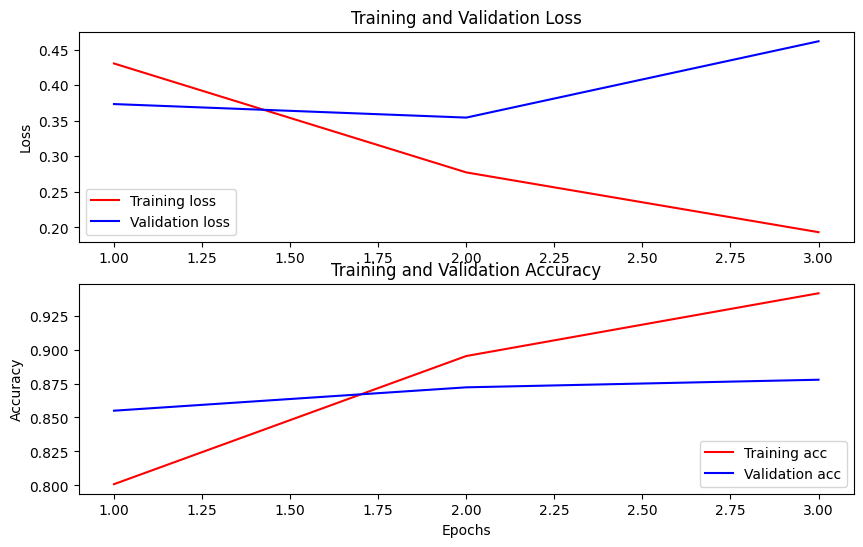

In [40]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [41]:
dataset_name = 'imdb'
saved_model_path = './{}_XML_RoBERTa'.format(dataset_name.replace('/', '_'))

In [42]:
def print_predictions(inputs, results):
    for i in range(len(inputs)):
        sentiment = "Positive" if results[i][0] >= 0.5 else "Negative"
        score = results[i][0]
        print(f'Input: {inputs[i]:<90} | Sentiment: {sentiment} | Score: {score:.6f}')
    print()

examples = [
    'Captivating, heartwarming film. Superb acting, engaging plot. A must-watch for a feel-good experience.',
    'The movie was great!',
    'Dull plot, unconvincing acting. Lacks depth. Disappointing overall. Not recommended for a satisfying movie experience.',
    'Amid convoluted storytelling, insipid characters, and erratic pacing, the movie falters, failing to captivate or engage.',
    'The movie was terrible...'
]


original_results = tf.sigmoid(classifier_model(tf.constant(examples)))


print('Results from the model in memory:')
print_predictions(examples, original_results)


Results from the model in memory:
Input: Captivating, heartwarming film. Superb acting, engaging plot. A must-watch for a feel-good experience. | Sentiment: Positive | Score: 0.997701
Input: The movie was great!                                                                       | Sentiment: Positive | Score: 0.997010
Input: Dull plot, unconvincing acting. Lacks depth. Disappointing overall. Not recommended for a satisfying movie experience. | Sentiment: Negative | Score: 0.000801
Input: Amid convoluted storytelling, insipid characters, and erratic pacing, the movie falters, failing to captivate or engage. | Sentiment: Negative | Score: 0.001420
Input: The movie was terrible...                                                                  | Sentiment: Negative | Score: 0.000649

